In [11]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
import umap

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [12]:
umap.__file__

'/home/cstansbu/.local/lib/python3.9/site-packages/umap/__init__.py'

# Load our data

In [13]:
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run3/scanpy/anndata_distance.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata_distance.h5ad"

adata = sc.read(fpath, cache=False)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")
adata

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8343 × 13941
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'UMAP 1', 'UMAP 2', 'Fibroblast_mean', 'Fibroblast_max', 'Fibroblast_argmax', 'Fibroblast_highest_exp', 'HSC_mean', 'HSC_max', 'HSC_argmax', 'HSC_highest_exp', 'clusters', 'cluster_name'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

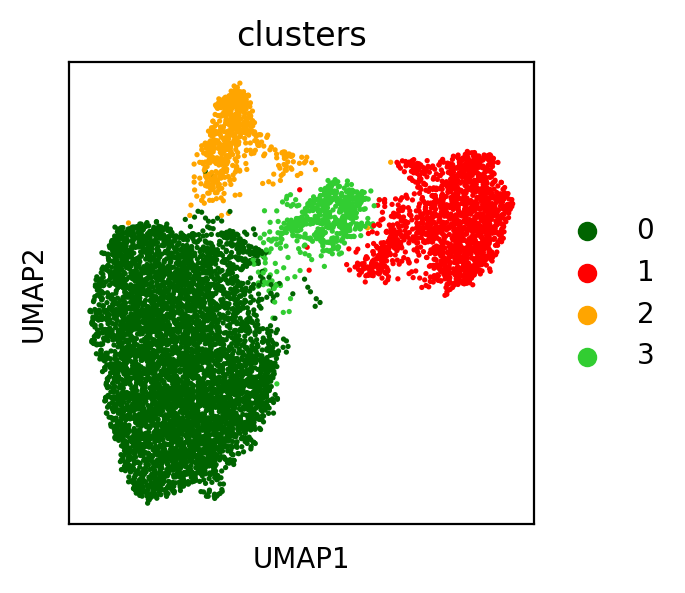

In [14]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(adata, color='clusters')

# Load tabula sapiens

In [15]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/tabula_sapiens_filtered.h5ad"
sdf = sc.read_h5ad(fpath)

sc.pp.normalize_total(sdf, target_sum=1e6)

sdf

AnnData object with n_obs × n_vars = 27346 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

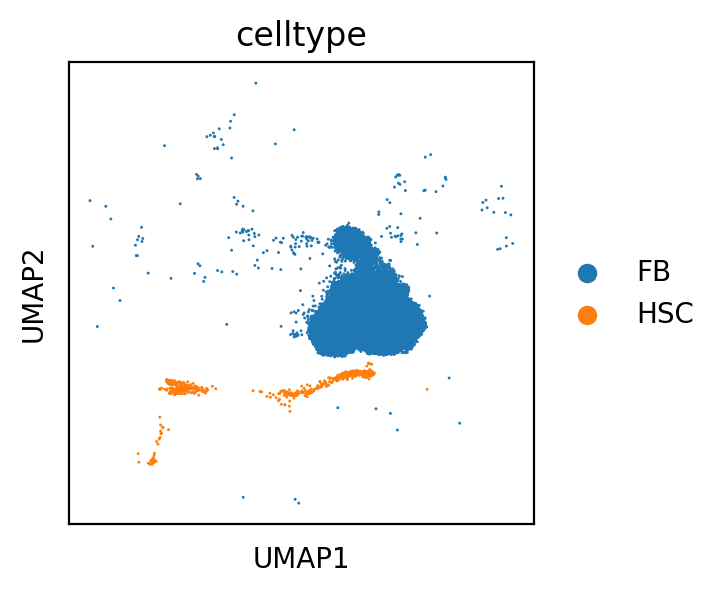

In [16]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(sdf, color='celltype')

In [17]:
sdf.obs[['celltype', 'organ_tissue']].value_counts()

celltype  organ_tissue   
FB        Fat                8459
          Vasculature        5867
          Bladder            5557
          Thymus             3924
          Trachea            1239
          Large_Intestine     953
HSC       Bone_Marrow         617
FB        Tongue              251
          Prostate            223
          Small_Intestine     113
HSC       Spleen               73
          Blood                70
dtype: int64

# Marker genes

In [18]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()


pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
hp = getGenes(pandDf, 'Hematopoietic stem cells')

print(f"FB genes: {len(fb)}")
print(f"HP genes: {len(hp)}")

FB genes: 179
HP genes: 88


# get minimal overlapping gene set

In [19]:

ref_genes = sdf.var.copy()
data_genes = adata.var.copy()
data_genes = data_genes.reset_index(drop=False)


gene_df = pd.merge(data_genes[['gene_name', 'gene_id']],
                   ref_genes[['gene_symbol',]],
                   how='left',
                   left_on='gene_name',
                   right_on='gene_symbol')

gene_df['is_fb_marker'] = np.where(gene_df['gene_name'].isin(fb), True, False)
gene_df['is_hsc_marker'] = np.where(gene_df['gene_name'].isin(hp), True, False)

print(gene_df['is_fb_marker'].value_counts())
print()
print(gene_df['is_hsc_marker'].value_counts())
print()

gene_df.head()

False    13838
True       126
Name: is_fb_marker, dtype: int64

False    13895
True        69
Name: is_hsc_marker, dtype: int64



,gene_name,gene_id,gene_symbol,is_fb_marker,is_hsc_marker
0,ATAD3B,ENSG00000160072,ATAD3B,False,False
1,SKI,ENSG00000157933,SKI,False,False
2,PEX14,ENSG00000142655,PEX14,False,False
3,PLCH2,ENSG00000149527,PLCH2,False,False
4,HES3,ENSG00000173673,HES3,False,False


In [20]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# define the distance to reference signature

In [ ]:
def distance_to_mean(adata, sdf, gene_df, target='hsc', metric='cosine'):
    """A function to compute the distance between our cells and the target signature
    """
    if target == 'hsc':
        marker_set = 'is_hsc_marker'
        target_type = 'HSC'
    elif target == 'fb':
        marker_set = 'is_fb_marker'
        target_type = 'FB'
    else:
        raise ValueError('`target` may be either `hsc` or `fb`')

    # define reference structure
    target_genes = gene_df[gene_df[marker_set]]
    mask = (sdf.obs['celltype'] == target_type)

    # define reference subset
    ref = sdf[mask, target_genes['gene_symbol'].to_list()]
    target_signature = ref.to_df()

    # reshape the mean expresison vector
    target_signature = target_signature.mean(axis=0)
    target_vector = target_signature.to_numpy()
    target_vector = target_vector.reshape(1, -1)

    # subset the genes and extract expression
    cells = adata[:, target_genes['gene_id'].to_list()]
    cells = cells.to_df()

    d = scipy.spatial.distance.cdist(cells, target_vector, metric=metric)
    d = pd.DataFrame(d, index=cells.index)
    d.columns = ['distance']
    return d

In [ ]:
metric = 'cosine'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to HSC")


sns.despine()

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to HSC")

sns.despine()

In [ ]:
# statistical test
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)


mask = (d['cluster_name'] == 'C2')

in_group = d[mask]
out_group = d[~mask]

print(f"{in_group.shape=} {out_group.shape=}")

score, pval = scipy.stats.ttest_ind(in_group['distance'], 
                                    out_group['distance'],
                                    equal_var=False,
                                    alternative='less')

print(f"{pval=}")
print(f"{in_group['distance'].mean()=:.3f}")
print(f"{out_group['distance'].mean()=:.3f}")

In [ ]:
# statistical test
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)


mask = (d['cluster_name'] == 'C2')

in_group = d[mask]
out_group = d[~mask]

print(f"{in_group.shape=} {out_group.shape=}")

score, pval = scipy.stats.ttest_ind(in_group['distance'], 
                                    out_group['distance'],
                                    equal_var=False,
                                    alternative='greater')

print(f"{pval=}")
print(f"{in_group['distance'].mean()=:.3f}")
print(f"{out_group['distance'].mean()=:.3f}")

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to FB")

sns.despine()

In [ ]:
metric = 'cosine'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to FB")

sns.despine()

# Distance Plots

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))
d = d[d['distance_norm'] < 0.99]

gx = d.groupby(['cluster_name'])['distance_norm'].mean()
gx = gx.reset_index(drop=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.5

sns.stripplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              jitter=0.3,
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

sns.scatterplot(data=gx, 
                x='distance_norm', 
                y='cluster_name',
                hue='cluster_name',
                zorder=3,
                palette=list(adata.uns['clusters_colors']),
                marker="o",
                linewidth=0.75,
                ec='k',
                s=30)

plt.gca().legend().remove()
plt.ylabel("Cluster")
plt.xlabel("Distance to HSC")
plt.gca().invert_xaxis()
plt.xticks([0, 1], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])

sns.despine()

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.25

sns.pointplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              markers='none',
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

ax = plt.gca()
plt.ylabel("")
plt.xlabel("Distance to HSC")
ax.invert_xaxis()
plt.xticks([0.71, 0.825], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])
plt.yticks([0, 1, 2, 3], ['Fibroblast', 'iHSC', 'Intermediate', 'Control'])
sns.despine()

gx = d.groupby(['cluster_name'])['distance_norm'].agg(['count', 'mean'])
gx = gx.reset_index(drop=False)

for y_val, row in gx.iterrows():
    label = row['count']
    x_val = row['mean']

    nudge = y_val + 0.2

    ax.text(x_val, 
            nudge, 
            label, 
            ha='center',
            fontsize=8,)
    

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.25

sns.pointplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              markers='none',
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

ax = plt.gca()
plt.ylabel("")
plt.xlabel("Distance to FB")
ax.invert_xaxis()
plt.xticks([0.53, 0.75], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])
plt.yticks([0, 1, 2, 3], ['Fibroblast', 'iHSC', 'Intermediate', 'Control'])
sns.despine()

gx = d.groupby(['cluster_name'])['distance_norm'].agg(['count', 'mean'])
gx = gx.reset_index(drop=False)

for y_val, row in gx.iterrows():
    label = row['count']
    x_val = row['mean']

    nudge = y_val + 0.2

    ax.text(x_val, 
            nudge, 
            label, 
            ha='center',
            fontsize=8,)

# full distance matrices

In [ ]:
def distance_to_each(adata, sdf, gene_df, target='hsc', metric='cosine'):
    """A function to compute the distance between our cells and the target signature
    """
    if target == 'hsc':
        marker_set = 'is_hsc_marker'
        target_type = 'HSC'
    elif target == 'fb':
        marker_set = 'is_fb_marker'
        target_type = 'FB'
    else:
        raise ValueError('`target` may be either `hsc` or `fb`')

    # define reference structure
    target_genes = gene_df[gene_df[marker_set]]
    mask = (sdf.obs['celltype'] == target_type)

    # define reference subset
    ref = sdf[mask, target_genes['gene_symbol'].to_list()]
    target_cells = ref.to_df()

    # subset the genes and extract expression
    cells = adata[:, target_genes['gene_id'].to_list()]
    cells = cells.to_df()

    d = scipy.spatial.distance.cdist(cells, target_cells, metric=metric)
    d = pd.DataFrame(d, index=cells.index, columns=target_cells.index)
    # print(d.shape)
    # d.columns = ['distance']
    return d

metric = 'cosine'
to_hsc = distance_to_each(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

to_fb = distance_to_each(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

print(f"{to_hsc.shape=}")
print(f"{to_fb.shape=}")


In [ ]:
obs = adata.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

colors = list(adata.uns['clusters_colors'])

fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

for i, (cluster, group) in enumerate(obs.groupby('cluster_name')):
    print(f"{cluster}...")
    group_idx = group.index
    group_dist = to_hsc.loc[group_idx]
    print(f"{group_dist.shape=}")

    gx = group_dist.agg(['mean', 'std'], axis=1)

    sns.histplot(data=gx, 
                 x='mean',
                 bins=21,
                 kde=True,
                 color=colors[i],
                 ax=axs[i])

    axs[i].set_title(f"{cluster} -> HSC")

plt.tight_layout()
sns.despine()    

In [ ]:
obs = adata.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

colors = list(adata.uns['clusters_colors'])

fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

for i, (cluster, group) in enumerate(obs.groupby('cluster_name')):
    print(f"{cluster}...")
    group_idx = group.index
    group_dist = to_fb.loc[group_idx]
    print(f"{group_dist.shape=}")

    gx = group_dist.agg(['mean', 'std'], axis=1)

    sns.histplot(data=gx, 
                 x='mean',
                 bins=21,
                 kde=True,
                 color=colors[i],
                 ax=axs[i])

    axs[i].set_title(f"{cluster} -> FB")

plt.tight_layout()
sns.despine()    

# paired distances

In [ ]:
metric = 'cosine'
to_fb = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

to_fb.columns = ['dist_to_fb']

to_hsc = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

to_hsc.columns = ['dist_to_hsc']

dist = pd.concat([to_fb, to_hsc], axis=1)
dist = pd.merge(adata.obs, dist, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

order = np.argsort(dist['cluster_name'])

sns.scatterplot(data=dist.iloc[order], 
                x='dist_to_fb',
                y='dist_to_hsc',
                s=5,
                alpha=0.5,
                ec='none',
                palette=list(adata.uns['clusters_colors']),
                hue='cluster_name')

sns.move_legend(plt.gca(),
                loc='upper right',
                title='Cluster',
                bbox_to_anchor=(1.2, 1))

plt.ylabel('Distance to HSC')
plt.xlabel('Distance to FB')
sns.despine()

In [ ]:
break

# Simple plots

In [ ]:
gene_df['gene_symbol'].isin(sdf.var.index.to_list()).sum()

In [ ]:
gene_df['gene_symbol'].shape

In [ ]:
sdf[:, 'ATAD3B']

In [ ]:
# define reference subset
mask = (sdf.obs['celltype'] == 'HSC')
# ref = sdf[ gene_df['gene_name'].to_list()]
# target_cells = ref.to_df()
# signature = target_cells.mean(axis=0)
# print(f"{signature.shape=}")

# plt.plot()

In [ ]:
plot

In [ ]:
# define reference structure
target_genes = gene_df[gene_df['is_hsc_marker']]
mask = (sdf.obs['celltype'] == 'HSC')

# define reference subset
ref = sdf[mask, target_genes['gene_symbol'].to_list()]
target_cells = ref.to_df()

mean_exp = target_cells.mean(axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plt.plot(mean_exp.values, lw=1, c='k')


sns.despine()


# # subset the genes and extract expression
# cells = adata[:, target_genes['gene_id'].to_list()]
# cells = cells.to_df()


In [ ]:
plt.plot(target_cells.mean(axis=1))

In [ ]:
cells.head()

In [ ]:
break

# combine data sets

In [ ]:
def extract_objects(adata, sdf, gene_list):    
    our_data = adata[:, gene_list['gene_id'].to_list()]
    ref_data = sdf[:, gene_list['gene_symbol'].to_list()]
    return our_data, ref_data

def merge_counts(adata, sdf, gene_list, raw=True, sample=None):
    """A function to build a new anndata 
    object with the raw counts from both datasets """
    print(f"Using {gene_list.shape[0]} genes...")

    our_data, ref_data = extract_objects(adata, sdf, gene_list)

    if raw:
        print(f"extracting raw counts...")
        our_df = our_data.to_df(layer='counts')
        ref_df = ref_data.to_df(layer='raw_counts')
    else:
        our_df = our_data.to_df()
        ref_df = ref_data.to_df()
        
    # standardize the column names
    our_df.columns = gene_list['gene_name'].to_list()
    ref_df.columns = gene_list['gene_name'].to_list()
    
    # merge expression data
    data_df = pd.concat([our_df, ref_df])
    
    print(f"{our_df.shape=}")
    print(f"{ref_df.shape=}")
    print(f"{data_df.shape=}")

    # get observation data
    our_obs = our_data.obs.copy()
    our_obs['set'] = 'our_data'
    our_obs = our_obs[['cluster_name','set']]
    
    ref_obs = ref_data.obs.copy()
    ref_obs['set'] = 'ref_data'
    ref_obs = ref_obs[['organ_tissue', 'set', 'celltype']]
    
    # merge obs data
    obs_data = pd.concat([our_obs, ref_obs])
    
    print()
    print(f"{obs_data.shape=}")
    
    var_df = gene_list.copy()
    var_df = var_df.set_index('gene_name')

    print(f"{var_df.shape=}")
    
    data = sc.AnnData(data_df, 
                  var=var_df,
                  obs=obs_data)

    if not sample is None:
        data = sc.pp.subsample(data, fraction=sample, copy=True)

    return data

# all genes
mask = (gene_df['gene_symbol'].notna())
gene_list = gene_df[mask].reset_index(drop=True)

# # random genes
# mask = (gene_df['gene_symbol'].notna())
# gene_list = gene_df[mask].reset_index(drop=True)
# gene_list = gene_list.sample(1000)

data = merge_counts(adata, sdf, gene_list, sample=None)
data

In [ ]:
break

# Joint embedding 

In [ ]:
min_distance = 1.0
spread = 1.0
NPCA = 10
knn = 11
n_genes = 1000
target_sum = 1e4
sample = None

# define dataset
mask = (gene_df['gene_symbol'].notna())
gene_list = gene_df[mask].reset_index(drop=True)
data = merge_counts(adata, sdf, gene_list, sample=sample)
print(data)

# simple preprocessing
sc.pp.normalize_total(data, target_sum=target_sum)
sc.pp.log1p(data)
sc.pp.combat(data, key='set',) # regress out batch effects
sc.pp.highly_variable_genes(data, 
                            n_top_genes=n_genes, 
                            batch_key='set')

# PCA
sc.tl.pca(data, n_comps=NPCA, use_highly_variable=True)
sc.pl.pca_variance_ratio(data, n_pcs=30)

sc.pp.neighbors(data, n_neighbors=knn, n_pcs=NPCA)

sc.tl.umap(data, min_dist=min_distance, spread=spread)
sc.pl.umap(data, color=['set', 'celltype', 'cluster_name'])


# joint embedding on marker genes

In [ ]:
min_distance = 1.0
spread = 1.0
NPCA = 10
knn = 31
target_sum = 1e3
sample = None

# define dataset
mask = (gene_df['is_fb_marker']) ^ (gene_df['is_hsc_marker'])
gene_list = gene_df[mask]
data = merge_counts(adata, sdf, gene_list, sample=sample)
print(data)

# simple preprocessing
sc.pp.normalize_total(data, target_sum=target_sum)
sc.pp.log1p(data)
sc.pp.combat(data, key='set',) # regress out batch effects

# PCA
sc.tl.pca(data, n_comps=NPCA, use_highly_variable=False)
sc.pl.pca_variance_ratio(data, n_pcs=30)

sc.pp.neighbors(data, n_neighbors=knn, n_pcs=NPCA)

sc.tl.paga(data, groups='set')
sc.pl.paga(data, plot=False)

sc.tl.umap(data, 
           init_pos='paga',
           min_dist=min_distance, 
           spread=spread)

sc.pl.umap(data, color=['set', 'celltype', 'cluster_name'])

# imputation of marker genes with MAGIC

In [ ]:
min_distance = 2.0
spread = 0.5
NPCA = 9
knn = 11
target_sum = 1e4
sample = None

# define dataset
mask = (gene_df['is_fb_marker']) ^ (gene_df['is_hsc_marker'])
gene_list = gene_df[mask]
data = merge_counts(adata, sdf, gene_list, sample=sample)
print(data)

# simple preprocessing
sc.pp.normalize_total(data, target_sum=target_sum)
sc.pp.log1p(data)
sc.pp.combat(data, key='set',) # regress out batch effects

sce.pp.magic(data, name_list='all_genes', knn=10)

# PCA
sc.tl.pca(data, n_comps=NPCA, use_highly_variable=False)
sc.pl.pca_variance_ratio(data, n_pcs=30)

sc.pp.neighbors(data, n_neighbors=knn, n_pcs=NPCA)

sc.tl.paga(data, groups='set')
sc.pl.paga(data, plot=False)

sc.tl.umap(data, 
           init_pos='paga',
           min_dist=min_distance, 
           spread=spread)

sc.pl.umap(data, color=['set', 'celltype', 'cluster_name'])


# lift-over integration

In [ ]:
break

# combine datasets

In [ ]:
mask = (gene_df['is_fb_marker']) ^ (gene_df['is_hsc_marker'])
gene_list = gene_df[mask]
print(f"{gene_list.shape=}")

our_data = adata[:, gene_list['gene_id'].to_list()]
ref_data = sdf[:, gene_list['gene_symbol'].to_list()]

# get expression
our_df = our_data.to_df(layer='counts')
ref_df = ref_data.to_df(layer='raw_counts')

# standardize the column names
our_df.columns = gene_list['gene_name'].to_list()
ref_df.columns = gene_list['gene_name'].to_list()

# merge expression data
data_df = pd.concat([our_df, ref_df])
print(f"{our_df.shape=} {ref_df.shape=} {data_df.shape=}")

# get observation data
our_obs = our_data.obs.copy()
our_obs['set'] = 'our_data'
our_obs = our_obs[['cluster_name','set']]

ref_obs = ref_data.obs.copy()
ref_obs['set'] = 'ref_data'
ref_obs = ref_obs[['organ_tissue', 'set', 'celltype']]

# merge obs data
obs_data = pd.concat([our_obs, ref_obs])
print(f"{obs_data.shape=}")


var_df = gene_list.copy()
var_df = var_df.set_index('gene_name')

data = sc.AnnData(data_df, 
                  var=var_df,
                  obs=obs_data)
data

# Reference projection

In [ ]:
def normalize_column(column):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(column.to_numpy().reshape(-1, 1))

TOP_N_GENES = 5000
    
mask = (gene_df['gene_symbol'].notna())
gene_list = gene_df[mask].reset_index(drop=True)
print(f"{gene_list.shape=}")

our_data = adata[:, gene_list['gene_id'].to_list()]
ref_data = sdf[:, gene_list['gene_symbol'].to_list()]

gene_list['data_mean_exp'] = np.ravel(our_data.X.mean(axis=0))
gene_list['ref_mean_exp'] = np.ravel(ref_data.X.mean(axis=0))

gene_list['data_mean_exp_norm'] = normalize_column(gene_list['data_mean_exp'])
gene_list['ref_mean_exp_norm'] = normalize_column(gene_list['ref_mean_exp'])

gene_list['score'] = gene_list['data_mean_exp_norm'] + gene_list['ref_mean_exp_norm']

r_sq, pval =  scipy.stats.pearsonr(gene_list['data_mean_exp'], 
                                   gene_list['ref_mean_exp'])

print(f"{r_sq=:.3f} {pval=:.6f}") 

gene_list = gene_list.sort_values(by='score', ascending=False)

print(f"{gene_list.shape=}")
gene_list = gene_list.head(TOP_N_GENES)
print(f"{gene_list.shape=}")
gene_list.head()

In [ ]:
our_data = adata[:, gene_list['gene_id'].to_list()]
ref_data = sdf[:, gene_list['gene_symbol'].to_list()]

print(our_data)
print()
print(ref_data)

In [ ]:
break

In [ ]:
"""UMAP embedding for plotting """
n_neighbors = 21
min_dist = 1.0
mappy = umap.UMAP(n_components=2, 
                  n_neighbors=n_neighbors,
                  min_dist=min_dist)

X = ref_data.to_df()
obs = ref_data.obs

# fit the model
mappy.fit(X)
edf = mappy.transform(X)

edf = pd.DataFrame(edf, 
                   index=X.index, 
                   columns=['UMAP1', 'UMAP2'])

edf = pd.concat([edf, obs], axis=1)

print(f"{edf.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=edf, 
                x='UMAP1',
                y='UMAP2',
                hue='celltype',
                palette=['green', 'red'],
                ec='none',
                alpha=0.5,
                s=2)

sns.move_legend(plt.gca(), 
                loc='upper right',
                title='Cell Type',
               )

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.xticks([])
plt.yticks([])
sns.despine()

edf.head()

In [ ]:
hue_order = list(edf['organ_tissue'].unique())
hue_order

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sns.scatterplot(data=edf, 
                x='UMAP1',
                y='UMAP2',
                hue='organ_tissue',
                palette='turbo',
                hue_order=hue_order,
                ec='k',
                alpha=0.5,
                s=3)

sns.move_legend(plt.gca(), 
                loc='upper right',
                title='Tissue',
                frameon=False,
                bbox_to_anchor=(1.7, 1),
               )

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.xticks([])
plt.yticks([])
sns.despine()

# Transform

In [ ]:
Y = our_data.to_df()
obs = our_data.obs.copy()
qdf = mappy.transform(Y)

qdf = pd.DataFrame(qdf, 
                   index=Y.index, 
                   columns=['UMAP1', 'UMAP2'])

qdf = pd.concat([qdf, obs], axis=1)
print(f"{qdf.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=edf, 
                x='UMAP1',
                y='UMAP2',
                color='grey',
                ec='none',
                alpha=0.5,
                zorder=1,
                s=3)

sns.scatterplot(data=qdf, 
                x='UMAP1',
                y='UMAP2',
                hue='cluster_name',
                ec='none',
                alpha=0.5,
                zorder=2,
                s=3)

# Combined embedding

In [ ]:
def normalize_column(column):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(column.to_numpy().reshape(-1, 1))

TOP_N_GENES = 10000
    
mask = (gene_df['gene_symbol'].notna())
gene_list = gene_df[mask].reset_index(drop=True)
print(f"{gene_list.shape=}")

our_data = adata[:, gene_list['gene_id'].to_list()]
ref_data = sdf[:, gene_list['gene_symbol'].to_list()]

gene_list['data_mean_exp'] = np.ravel(our_data.X.mean(axis=0))
gene_list['ref_mean_exp'] = np.ravel(ref_data.X.mean(axis=0))

gene_list['data_mean_exp_norm'] = normalize_column(gene_list['data_mean_exp'])
gene_list['ref_mean_exp_norm'] = normalize_column(gene_list['ref_mean_exp'])

gene_list['score'] = gene_list['data_mean_exp_norm'] + gene_list['ref_mean_exp_norm']

r_sq, pval =  scipy.stats.pearsonr(gene_list['data_mean_exp'], 
                                   gene_list['ref_mean_exp'])

print(f"{r_sq=:.3f} {pval=:.6f}") 

gene_list = gene_list.sort_values(by='score', ascending=False)

print(f"{gene_list.shape=}")
gene_list = gene_list.head(TOP_N_GENES)
print(f"{gene_list.shape=}")
gene_list.head()

In [ ]:
our_data = adata[:, gene_list['gene_id'].to_list()]
ref_data = sdf[:, gene_list['gene_symbol'].to_list()]

print(our_data)
print()
print(ref_data)

In [ ]:
break

# Combined embedding 

In [ ]:
# simple standardization
# preprocess
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)
data

In [ ]:
# mathematical processing
n_comps = 100
n_neighbors = 61
neighbors_n_pcs = 50
min_dist = 0.8
spread = 1.0

sc.tl.pca(data, 
          n_comps=n_comps)

sc.pp.neighbors(data,
                n_neighbors=n_neighbors,
                n_pcs=neighbors_n_pcs)

sc.tl.umap(data, 
           min_dist,
           spread)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sc.pl.umap(data, color='set')

In [ ]:
sc.pl.umap(data, color='celltype')

In [ ]:
sc.pl.umap(data, color='cluster_name')

In [ ]:
break

In [ ]:
adata

In [ ]:
hsc_genes = gene_df[gene_df['is_hsc_marker']]
mask = (sdf.obs['celltype'] == 'HSC')

hsc_ref = sdf[mask, hsc_genes['gene_symbol'].to_list()]

# define the signature
hsc_signature = hsc_ref.to_df()
hsc_signature = hsc_signature.mean(axis=0)
hsc_signature.head()

# Define distance to HSC

In [ ]:
# subset the genes
pdf = adata[:, hsc_genes['gene_id'].to_list()]

# extract the expression
cells = pdf.to_df()

# reshape the signatrue vector
hsc_vec = hsc_signature.to_numpy()
hsc_vec = hsc_vec.reshape(1, -1)
print(f"{cells.shape=} {hsc_signature.shape=} {hsc_vec.shape=}")

metric = 'cosine'
d = scipy.spatial.distance.cdist(cells, hsc_vec, metric=metric)
d = pd.DataFrame(d, index=cells.index)
d.columns = [metric]
d = pd.merge(adata.obs, d,
             how='left',
             left_index=True,
             right_index=True,)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y=metric,
            showfliers=False)

sns.despine()

In [ ]:
break

# Distance from Mean Signature

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.05, 
                point['y'],
                str(point['val']),
                fontsize=4,
                fontweight='bold')

In [ ]:
signatures = {}
colors = ['#BEE0B4', '#EBAFAF',]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4
fig, axs = plt.subplots(3, 1)

for i, (celltype, group) in enumerate(adata.obs.groupby('clusters')):
    print(f"C{int(celltype)+1} {group.shape=}")

    X = adata[group.index, :].X
    print(f"{X.shape=}")

    sig = np.mean(X, axis=0)
    signatures[celltype] = sig.copy()

    axs[i].plot(sig, c=colors[i])
    axs[i].set_xticks([])
    axs[i].set_ylabel('TPM')
    axs[i].set_title(f"C{int(celltype) + 1} Signature")


diff = signatures['0'] - signatures['1']

axs[2].plot(diff, c='grey', zorder=1)
axs[2].set_xticks([])
axs[2].set_ylabel('TPM')
axs[2].set_title(f"Difference")

diff_ind = np.where(np.abs(diff) > 1.5)

axs[2].scatter(diff_ind, 
               diff[diff_ind], 
               zorder=3, 
               c='r', 
               ec='k',
               lw=0.5,
               s=10,)

axs[2].axhline(y=0, lw=1, zorder=2, c='k')
genes  = adata.var.iloc[diff_ind]['gene_name'].values

for x, y, val in zip(diff_ind[0], diff[diff_ind], genes):
    # print(x, y, val)
    buff = 100
    ha = 'left'
    if val == 'TOMM70':
        buff = -50
        ha = 'right'

    axs[2].text(x+buff, y, str(val),
                ha=ha,
                fontsize=4,
                fontweight='bold')

plt.tight_layout()
sns.despine()

In [ ]:
metric = 'correlation'

res = []

for i, (cluster, group) in enumerate(adata.obs.groupby('clusters')):
    print(f"C{int(cluster)+1} {group.shape=}")
    X = adata[group.index, :].X

    for cluster_comp, sig in signatures.items():
        d = scipy.spatial.distance.cdist(X, sig.reshape(1, -1), metric=metric)
        d = pd.DataFrame(d)
        d.columns = [metric]
        d['expression'] = f'C{int(cluster)+1}'
        d['signature'] = f'C{int(cluster_comp)+1}'
        
        res.append(d)

res = pd.concat(res)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 3

fig, axs = plt.subplots(1, 2)


for i, (cluster, group) in enumerate(res.groupby('expression')):
    print(i, cluster)
    
    sns.histplot(data=group, 
                 x=metric, 
                 bins=50,
                 kde=True,
                 ax=axs[i],
                 palette=colors,
                 hue='signature')

    axs[i].set_xlabel(f'{metric.title()} Distance')
    # axs[i].set_xlabel(f'Jensen-Shannon Divergence')
    axs[i].set_ylabel('n Cells')
    axs[i].set_title(f"{cluster} Cells")
    
    if i == 0:
        axs[i].legend().remove()
    else:
        sns.move_legend(axs[i],
                        title="Signature",
                        loc='upper left',
                        frameon=False)

plt.tight_layout()
sns.despine()

# Reprogramming Distance

In [ ]:
# the crudest version is the distribution along the first UMAP axis
pdx = adata.obs.copy()

pdx['cluster_name'] = pdx['clusters'].astype(int).apply(lambda x: f"C{x+1}")
pdx = pdx.sort_values(by='cluster_name')
pdx['y_stub'] = 1

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(data=pdx, 
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                palette=['#BEE0B4', '#EBAFAF',],
                alpha=alpha,
                s=size,
                ec='none')



plt.yticks([])
plt.xticks([])

# label on data
ax = plt.gca()

all_pos = (
        pdf.groupby('cluster_name')[['UMAP 1', 'UMAP 2']]
        .median()
        .sort_index()
    )

for label, x_pos, y_pos in all_pos.itertuples():
    ax.text(
        x_pos,
        y_pos,
        label,
        weight='bold',
        verticalalignment="center",
        horizontalalignment="center",
        fontsize='15',
    )

ax = plt.gca()
ax.legend().remove()
sns.despine()

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="15%")


sns.scatterplot(data=pdx.sample(100), 
                x='UMAP 1',
                y='y_stub',
                hue='clusters',
                marker="|",
                alpha=0.6,
                s=1000,
                ax=cax,
                zorder=2,
                palette=colors)

cax.set_ylim([0.99, 1.1])
cax.axhline(y=1.02, c='k', lw=0.5, zorder=1,)
cax.set_yticks([])
cax.set_xticks([])

cax.legend().remove()

cax.set_ylabel("")
cax.set_xlabel("Reprogramming Distance")
sns.despine(left=True, bottom=True)

In [ ]:
# A slightly better method is to fit a line to the cluster centroids
pdx = adata.obs.copy()

pdx['cluster_name'] = pdx['clusters'].astype(int).apply(lambda x: f"C{x+1}")
pdx = pdx.sort_values(by='cluster_name')
pdx['y_stub'] = 1

centroids = pdf.groupby('cluster_name')[['UMAP 1', 'UMAP 2']].median().reset_index(drop=False)

def fit(centroids):
    coords = centroids['UMAP 1'].to_numpy()
    A = np.vstack((coords, np.ones(2))).T
    b = centroids['UMAP 2'].to_numpy()
    return np.linalg.lstsq(A, b, rcond=None)[0]

def get_func(centroids):
    slope, intercept = fit(centroids)
    return lambda x: (x * slope) + intercept

def get_rotation(centroids):
    slope, intercept = fit(centroids)
    angle = np.arctan(-1 * slope)
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

# build the y-line
lin_func = get_func(centroids)
X = np.linspace(pdx['UMAP 1'].min(), pdx['UMAP 1'].max(), 10)
y = lin_func(X)

# get the rotation matrix
rmat = get_rotation(centroids)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 11, 4
fig, axs = plt.subplots(1, 3)


sns.scatterplot(data=pdx, 
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                palette=['#BEE0B4', '#EBAFAF',],
                alpha=0.8,
                s=10,
                zorder=1,
                ax=axs[0],
                ec='none')

sns.scatterplot(data=centroids, 
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                palette=['#BEE0B4', '#EBAFAF',],
                alpha=1.0,
                marker='s',
                s=40,
                zorder=3,
                ax=axs[0],
                linewidth=1,
                ec='k')

axs[0].plot(X, y, zorder=2, c='k',)
axs[0].legend().remove()
axs[0].set_xticks([])
axs[0].set_yticks([])



new_points = np.dot(pdx[['UMAP 1', 'UMAP 2']].to_numpy(), rmat)

pdx['U1'] = new_points[:, 0]
pdx['U2'] = new_points[:, 1]

sns.scatterplot(data=pdx, 
                x='U1',
                y='U2',
                hue='cluster_name',
                palette=['#BEE0B4', '#EBAFAF',],
                alpha=0.8,
                s=10,
                zorder=1,
                ax=axs[1],
                ec='none')

axs[1].legend().remove()
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].axhline(y=pdx['U2'].mean(), zorder=2, c='k',)


sns.scatterplot(data=pdx.sample(200), 
                x='UMAP 1',
                y='y_stub',
                hue='clusters',
                marker="|",
                alpha=0.6,
                s=1000,
                ax=axs[2],
                zorder=2,
                palette=colors)

axs[2].legend().remove()
axs[2].set_xlabel("Reprogramming Distance")
axs[2].set_ylabel("")
axs[2].axhline(y=1, zorder=2, c='k',)
axs[2].set_xticks([])
axs[2].set_yticks([])

sns.despine()
plt.tight_layout()

In [ ]:
t = [x for x in hp if x in adata.var['gene_name'].to_list()]
print(len(t))
print(sorted(t))

In [ ]:
gene_list = [
    'C1S',
    'FSTL1',
    'CD34', 
    'MGST1', 
    
] # must be q square

n = len(gene_list)
pltn = int(np.sqrt(n))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
fig, axs = plt.subplots(pltn, pltn)
axs = axs.ravel()

for i, g in enumerate(gene_list):
    gene_name = adata.var[adata.var['gene_name'] == g].index[0]
    print(g, gene_name)
    v = adata[:, [gene_name]].X


    gdf = adata.obs.copy()
    gdf['exp'] = np.ravel(v)

    order = np.argsort(gdf['exp'])

    axs[i].scatter(gdf['UMAP 1'][order], 
                   gdf['UMAP 2'][order],
                   c=gdf['exp'][order],
                   s=5,
                   alpha=0.8,
                   ec='none')
    
    axs[i].set_title(g)

    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

sns.despine()
plt.tight_layout()

# differential expression analysis

In [ ]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4
sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        sharey=False, 
                        gene_symbols='gene_name')

deg = sc.get.rank_genes_groups_df(adata, 
                                  gene_symbols='gene_name',
                                  group=None)

deg.head()

In [ ]:
# enrichments for each cluster

alpha = 0.05
fc_threshold = 0.0
n_query = 10

# db = 'ontology'
# db = 'TRRUST_Transcription_Factors_2019'
db = 'PanglaoDB_Augmented_2021'

for cluster, group in deg.groupby('group'):

    group = group[group['pvals_adj'] < alpha]
    group = group[group['logfoldchanges'].abs() > fc_threshold]
    group = group.reset_index(drop=True)

    group = group.sort_values(by='logfoldchanges', ascending=False)
    group = group.head(n_query)

    gene_names = adata.var.loc[group['names'].to_list()]['gene_name'].to_list()
    
    edf = gget.enrichr(gene_names, database=db)
    print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10))
    
    print()

# Distance to target

In [ ]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/tabula_sapiens_filtered.h5ad"
sdf = sc.read_h5ad(fpath)

sc.pp.normalize_total(sdf, target_sum=1e6)
sc.pp.log1p(sdf)

sdf

In [ ]:
cellmap = {
    'fibroblast' : 'FB',
    'hematopoietic stem cell' : 'HSC',
}

sdf.obs['celltype'] = sdf.obs['cell_ontology_class'].map(cellmap)

sdf.obs[['organ_tissue', 'celltype']].value_counts()

In [ ]:
# get the overlapping gene sets
our_genes = adata.var['gene_name'].unique()
ts_genes = sdf.var['gene_symbol'].unique()

print(f"{our_genes.shape=}")
print(f"{ts_genes.shape=}")

common_genes = np.intersect1d(our_genes, ts_genes)
print(f"{common_genes.shape=}")

In [ ]:
# generate aggregate signatures

exp_genes = adata.var['gene_name'].to_list()

cellmap = {
    'fibroblast' : 'FB',
    'hematopoietic stem cell' : 'HSC',
}

sdf.obs['celltype'] = sdf.obs['cell_ontology_class'].map(cellmap)

signatures = {}
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

fig, axs = plt.subplots(3, 1)

for i, celltype in enumerate(sdf.obs['celltype'].unique()):
    tmp = sdf[sdf.obs['celltype'] == celltype].copy()

    gene_list = tmp.var.drop_duplicates(subset='gene_symbol')
    v_genes = gene_list[gene_list['gene_symbol'].isin(common_genes)].index
  
    X = tmp[:, v_genes].X
    sig = np.mean(X, axis=0)
    print(X.shape, sig.shape)
    signatures[celltype] = sig.copy()

    axs[i].plot(sig.T, c=colors[i])
    axs[i].set_xticks([])
    axs[i].set_ylabel('TPM')
    axs[i].set_title(f"{celltype} Signature (Tabula Sapiens)")
    

    
diff = np.ravel(signatures['FB'] - signatures['HSC'])

axs[2].plot(diff, c='grey', zorder=1)
axs[2].set_xticks([])
axs[2].set_ylabel('TPM')
axs[2].set_title(f"Difference")

diff_ind = np.where(np.abs(diff) > 4.5)

print(f"{diff.shape=} {diff_ind[0].shape=}")

axs[2].scatter(diff_ind, 
               diff[diff_ind[0]], 
               zorder=3, 
               c='r', 
               ec='k',
               lw=0.5,
               s=10,)

axs[2].axhline(y=0, lw=1, zorder=2, c='k')
genes  = v_genes[diff_ind[0]]

for x, y, val in zip(diff_ind[0], diff[diff_ind[0]], genes):
    buff = 100
    ha = 'left'
    axs[2].text(x+buff, y, str(val),
                ha=ha,
                fontsize=4,
                fontweight='bold')

plt.tight_layout()
sns.despine()

# Global differences

In [ ]:
metric = 'euclidean'

res = []

for i, (cluster, group) in enumerate(adata.obs.groupby('clusters')):
    print(f"C{int(cluster)+1} {group.shape=}")
    v_gene_ids = adata.var[adata.var['gene_name'].isin(v_genes)].index
    X = adata[group.index, v_gene_ids].X

    for cluster_comp, sig in signatures.items():
        d = scipy.spatial.distance.cdist(X, sig.reshape(1, -1), metric=metric)
        d = pd.DataFrame(d)
        d.columns = [metric]
        d['expression'] = f'C{int(cluster)+1}'
        d['signature'] = f'{cluster_comp}'
        
        res.append(d)

res = pd.concat(res)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 3

fig, axs = plt.subplots(1, 2)

for i, (cluster, group) in enumerate(res.groupby('expression')):
    print(i, cluster)
    
    sns.histplot(data=group, 
                 x=metric, 
                 bins=50,
                 kde=True,
                 ax=axs[i],
                 palette=colors,
                 hue='signature')

    axs[i].set_xlabel(f'{metric.title()} Distance')
    # axs[i].set_xlabel(f'Jensen-Shannon Divergence')
    axs[i].set_ylabel('n Cells')
    axs[i].set_title(f"{cluster} Cells")
    
    if i == 0:
        axs[i].legend().remove()
    else:
        sns.move_legend(axs[i],
                        title="Signature",
                        loc='upper right',
                        frameon=False)

plt.tight_layout()
sns.despine()

# local distances

In [ ]:
# get overlapping gene sets
marker_genes = list(set(fb + hp))
print(f"{len(marker_genes)=}")


# get the overlapping gene sets
our_genes = [x for x in adata.var['gene_name'].to_list() if x in marker_genes]
ts_genes = [x for x in sdf.var['gene_symbol'].to_list() if x in marker_genes]

print(f"{len(our_genes)=}")
print(f"{len(ts_genes)=}")

common_genes = np.intersect1d(our_genes, ts_genes)
print(f"{common_genes.shape=}")
common_genes


In [ ]:
# generate aggregate signatures

exp_genes = adata.var['gene_name'].to_list()

cellmap = {
    'fibroblast' : 'FB',
    'hematopoietic stem cell' : 'HSC',
}

sdf.obs['celltype'] = sdf.obs['cell_ontology_class'].map(cellmap)

signatures = {}
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

fig, axs = plt.subplots(3, 1)

for i, celltype in enumerate(sdf.obs['celltype'].unique()):
    tmp = sdf[sdf.obs['celltype'] == celltype].copy()

    gene_list = tmp.var.drop_duplicates(subset='gene_symbol')
    v_genes = gene_list[gene_list['gene_symbol'].isin(common_genes)].index
  
    X = tmp[:, v_genes].X
    sig = np.mean(X, axis=0)
    print(X.shape, sig.shape)
    signatures[celltype] = sig.copy()

    axs[i].plot(sig.T, c=colors[i])
    axs[i].set_xticks([])
    axs[i].set_ylabel('TPM')
    axs[i].set_title(f"{celltype} Signature (Tabula Sapiens)")
        
diff = np.ravel(signatures['FB'] - signatures['HSC'])

axs[2].plot(diff, c='grey', zorder=1)
axs[2].set_ylabel('TPM')
axs[2].set_title(f"Difference")

diff_ind = np.where(np.abs(diff) > 4.5)

print(f"{diff.shape=} {diff_ind[0].shape=}")

axs[2].scatter(diff_ind, 
               diff[diff_ind[0]], 
               zorder=3, 
               c='r', 
               ec='k',
               lw=0.5,
               s=10,)

axs[2].axhline(y=0, lw=1, zorder=2, c='k')


genes  = v_genes[diff_ind[0]]
print(genes)

for x, y, val in zip(diff_ind[0], diff[diff_ind[0]], genes):
    buff = 1
    ha = 'left'

    axs[2].text(x+buff, y, str(val),
                ha=ha,
                fontsize=4,
                fontweight='bold')

plt.tight_layout()
sns.despine()

In [ ]:
metric = 'cosine'

res = []

colors2 = ['g', 'r']

for i, (cluster, group) in enumerate(adata.obs.groupby('clusters')):
    v_gene_ids = adata.var[adata.var['gene_name'].isin(common_genes)].index
    X = adata[group.index, v_gene_ids].X

    for cluster_comp, sig in signatures.items():
        print(f"C{int(cluster)+1} vs. {cluster_comp}")
        print(f"{X.shape=} {sig.shape=}")
        d = scipy.spatial.distance.cdist(X, sig.reshape(1, -1), metric=metric)
        d = pd.DataFrame(d)
        d.columns = ['distance']
        d['expression'] = f'C{int(cluster)+1}'
        d['signature'] = f'{cluster_comp}'
        res.append(d)

res = pd.concat(res, ignore_index=True)

t = res.replace([np.inf, -np.inf], np.nan)
gx = t.groupby(['expression', 'signature'], dropna=True).mean()
print(gx)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 3

fig, axs = plt.subplots(1, 2)

for i, (cluster, group) in enumerate(res.groupby('expression')):
    sns.histplot(data=group, 
                 x='distance', 
                 bins=50,
                 # kde=True,
                 ax=axs[i],
                 palette=colors,
                 hue='signature')

    t = group.replace([np.inf, -np.inf], np.nan)
    means = t.groupby(['signature'])['distance'].mean()
    for j, xc in enumerate(means):
        axs[i].axvline(x=xc, c=colors2[j], lw=2, alpha=0.6)
    
    axs[i].set_xlabel(f'{metric.title()} Distance')
    # axs[i].set_xlabel(f'Jensen-Shannon Divergence')
    axs[i].set_ylabel('n Cells')
    axs[i].set_title(f"{cluster} Cells")
    # axs[i].set_xscale('log')
    
    
    if i == 0:
        axs[i].legend().remove()
    else:
        sns.move_legend(axs[i],
                        title="Signature",
                        loc='upper left',
                        frameon=False)

plt.tight_layout()
sns.despine()

In [ ]:
buffer = 0.01
t = res.replace([np.inf, -np.inf], np.nan)
pdx = t.groupby(['expression', 'signature'], dropna=True).mean()
pdx = pdx.reset_index()
print(pdx)

nameMap = {
    'FB' : 'Fibroblst',
    'HSC' : 'HSC'
}

pdx['sig_names'] = pdx['signature'].map(nameMap)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5
sns.barplot(data=pdx, 
            x='expression', 
            y='distance',
            palette=colors,
            ec='k',
            hue='sig_names')

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel(f'')
plt.ylim([pdx['distance'].min()-buffer, pdx['distance'].max()+buffer])

sns.move_legend(plt.gca(),
                title="Signature",
                loc='upper right',
                bbox_to_anchor=(1.8, 1.05),
                frameon=False)

sns.despine()

In [ ]:
buffer = 0.01
t = res.replace([np.inf, -np.inf], np.nan)
pdx = t.groupby(['expression', 'signature'], dropna=True).mean()
pdx = pdx.reset_index()
print(pdx)

nameMap = {
    'FB' : 'Fibroblst',
    'HSC' : 'HSC'
}

pdx['sig_names'] = pdx['signature'].map(nameMap)
pdx = pdx[pdx['signature'] == 'FB']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5
sns.barplot(data=pdx, 
            x='expression', 
            y='distance',
            palette=['#BEE0B4'],
            ec='k',)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel(f'')
plt.ylim([pdx['distance'].min()-buffer, pdx['distance'].max()+buffer])
# '#BEE0B4', '#EBAFAF'

sns.despine()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 2.5

nameMap = {
    'FB' : 'Fibroblst',
    'HSC' : 'HSC'
}

res['sig_names'] = res['signature'].map(nameMap)

sns.boxplot(data=res,
            x='expression',
            y='distance',
            hue='sig_names',
            palette=colors,
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel(f'')
# plt.gca().set_xticklabels(['Fibroblast', 'HSC'])

sns.move_legend(plt.gca(),
                title="Signature",
                loc='upper right',
                bbox_to_anchor=(1.8, 1.05),
                frameon=False)

sns.despine()

# Pathway analysis

In [ ]:
def parseKEGG(pathId):
    genes = []
    results = REST.kegg_get(pathId).read()
    current_section = None
    for line in results.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            linesplit = line[12:].split("; ")
            gene_identifiers = linesplit[0]
            gene_id, gene_symbol = gene_identifiers.split()
    
            if not gene_symbol in genes:
                genes.append(gene_symbol)
    return genes

def getPathname(pathId):
    """A function to return the legg pathname"""
    result = REST.kegg_list(pathId).read()
    return result.split("\t")[1].split("-")[0].strip()


pid = "04110"
pgenes = parseKEGG(f"hsa{pid}")
pname = getPathname(f"hsa{pid}")
print(pname)
print(pgenes)

In [ ]:
pids = [
    "04110", 
    "03022", 
    "03020",
    "04310",
    "04330",
    "04115",
    "04218",
    "04810",
    "04710",
    "04713",
]

exp_genes = adata.var['gene_name'].to_list()

pways = {}

for pid in pids:
    pgenes = parseKEGG(f"hsa{pid}")
    pname = getPathname(f"hsa{pid}")
    gene_list = [x for x in pgenes if x in exp_genes]
    print(f"{pname} ({pid}) has {len(pgenes)} genes, {len(gene_list)} expressed")
    pways[pname] = gene_list

print('done')

In [ ]:
for pathway, gene_list in pways.items():
    gene_ids = adata.var[adata.var['gene_name'].isin(gene_list)].index
    adata.obs[f"{pathway}_mean"] = adata[:, gene_ids].X.mean(axis=1)
    adata.obs[f"{pathway}_median"] = np.median(adata[:, gene_ids].X, axis=1)
    adata.obs[f"{pathway}_max"] = adata[:, gene_ids].X.max(axis=1)
    
print('done')

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 7

pdf = adata.obs.copy()
fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

for i, pathway in enumerate(pways.keys()):
    column_name = f"{pathway}_max"

    # sort order
    order = np.argsort(pdf[column_name])

    sns.scatterplot(data=pdf.iloc[order], 
                    x='UMAP 1',
                    y='UMAP 2',
                    hue=column_name,
                    palette=cmap,
                    alpha=0.9,
                    ax=axs[i],
                    s=5,
                    # hue_norm=(0, 0.2),
                    ec='none')

    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].legend().remove()
    axs[i].set_title(pathway)

sns.despine()
plt.tight_layout()

In [ ]:
simul = [97.1, 96.3, 97.0]
print(np.mean(simul))
print(np.std(simul))

serial = [84.1, 87.2, 85.2]
print(np.mean(serial))
print(np.std(serial))

both = [84.1, 87.2, 85.2]
print(np.mean(serial))
print(np.std(serial))

